In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


# Plot setting

In [10]:
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True

# set color
color_dict = {}

viridis = cm.get_cmap('viridis', 5)
tab10 = cm.get_cmap('tab10', 10)

color_dict['consensus'] = tab10.colors[1]
color_dict['reference'] = tab10.colors[3]
color_dict['bps_core'] = tab10.colors[5]
color_dict['bps_noncore'] = tab10.colors[6]
color_dict['uni random'] = tab10.colors[7]
color_dict['prob random'] = tab10.colors[8]
color_dict['bandit'] = viridis.colors[0]
color_dict['bandit2'] = viridis.colors[1]
color_dict['bandit3'] = viridis.colors[2]
color_dict['bandit4'] = viridis.colors[3]

sns.set_palette(list(color_dict.values())[1:])

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../../data/pipeline_data/'
plot_path = '../../notebooks/paper_plots/'

In [11]:
plot_swarm_flag = True
plot_quant_flag = True
plot_scatter_flag = True

# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
    - C.2 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on all data
    - D.2 on each round
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 

In [12]:
# read data

df_e1 = pd.read_csv(folder_path + 'Results_e1.csv')
df_abc2 = pd.read_csv(folder_path + 'Results_abc2.csv')
df_abc1 = pd.read_csv(folder_path + 'Results_abc1.csv')

# Swarmplot

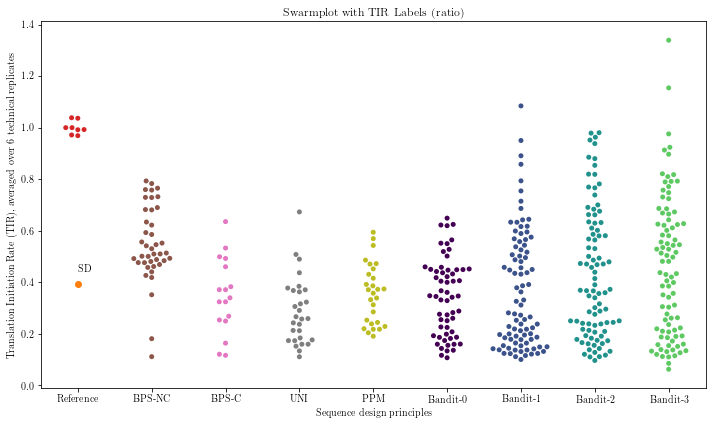

In [13]:
if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'BPS-NC', 'BPS-C', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
    y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
    axes.scatter(x = 0, y = y, color = color_dict['consensus'])
    axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Sequence design principles', ylabel='Translation Initiation Rate (TIR),\\ averaged over 6 technical replicates')
    axes.set_title('Swarmplot with TIR Labels (ratio)')
plt.tight_layout()
plt.savefig(plot_path + 'swarmplot.pdf')

# Quantile plot

In [14]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['BPS-C', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', label = str(quant), alpha = 0.8)
 
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend()
    plt.xticks(range(len(used_groups)), used_groups)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(plot_path + 'quantplot.pdf')

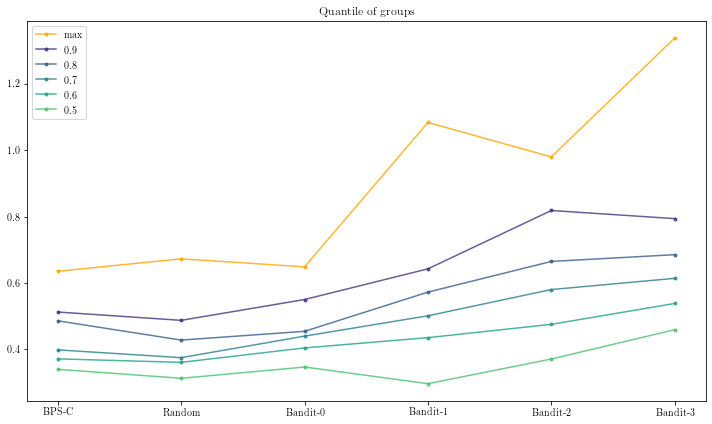

In [16]:
df_e1['Group2'] = df_e1['Group']
df_e1.loc[df_e1['Group2'] == 'UNI', 'Group2'] = 'Random'
df_e1.loc[df_e1['Group2'] == 'PPM', 'Group2'] = 'Random'

if plot_quant_flag:
    sns.set_palette('viridis') 
    quant_line(df_e1, 'Group2')
    

# Scatterplot

In [8]:
# copy from the pipeline for recommending round 2 seq
from codes.batch_ucb import *
from codes.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [9]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [10]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        fig, axes = plt.subplots(1,4, figsize = (20,6))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            axes[i].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[i].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[i].set_xlabel('True TIR')
            axes[i].set_ylabel('Predict TIR')
            axes[i].legend()
            axes[i].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[i].set_title('\n' + title[i] + 
                ' R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

        fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
        fig.subplots_adjust(top=0.85)
        plt.savefig(plot_path + 'scatter_' + plot_title + '.pdf')

In [11]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True):
    predictors = []
    for i in range(1,4):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = df['Round'] == i, title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag)
    predictors.append(predictor)
    return predictors
    

In [12]:
centering_flag = True
unit_norm_flag = True
df_abc1_TT_predictors = generate_predictors(df_abc1, kernel, embedding, centering_flag, unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_

#################################
  Evaluation   train 0 test 1
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.1818381249089286
Test:  1.6563659655331497
<function r2_score at 0x7f95e67f8b90>
Train:  0.7898224403285338
Test:  -0.8391571851389392
spearman cor:
Train:  SpearmanrResult(correlation=0.921531074586952, pvalue=0.0)
Test:  0.1452672795369425   0.1743708880974315
Test pred fit:  [0.00098973 0.84768222]
Test ave fit:  [ 0.03619848 -1.59273318]
coverage rate: 
Train:  0.9374407582938389
Test:  0.6179775280898876
#################################
  Evaluation   train 01 test 2
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.29166521519843724
Test:  1.4412988189222644
<function r2_score at 0x7f95e67f8b90>
Train:  0.6674575667117395
Test:  -0.5860607315588566
spearman cor:
Train:  SpearmanrResult(correlation=0.8680164927800581, pvalue=0.0)
Test:  0.5023070868820079   2.894856954571299e-07
Test p

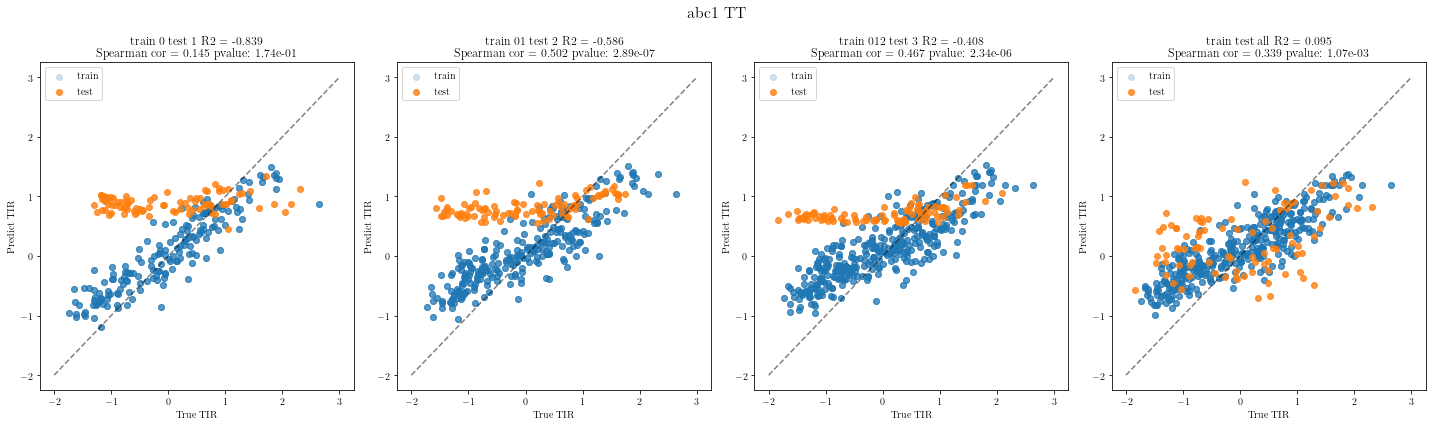

In [13]:
scatter_plot(df_abc1_TT_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc1 TT')

In [14]:
centering_flag = False
unit_norm_flag = False

df_abc1_FF_predictors = generate_predictors(df_abc1, kernel, embedding, centering_flag, unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigm

#################################
  Evaluation   train 0 test 1
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.2791374600542462
Test:  0.8420017336149175
<function r2_score at 0x7f95e67f8b90>
Train:  0.6773590236014795
Test:  0.06507766369199397
spearman cor:
Train:  SpearmanrResult(correlation=0.8495934357073237, pvalue=8.088677227497255e-295)
Test:  0.26721144024514815   0.011359478445848607
Test pred fit:  [0.00180214 0.02381745]
Test ave fit:  [ 0.03619848 -1.59273318]
coverage rate: 
Train:  0.7781990521327015
Test:  0.5955056179775281
#################################
  Evaluation   train 01 test 2
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.37335752674735706
Test:  0.7037968836238653
<function r2_score at 0x7f95e67f8b90>
Train:  0.5743159829786991
Test:  0.2255148027221714
spearman cor:
Train:  SpearmanrResult(correlation=0.7757297302970894, pvalue=1.3476e-319)
Test:  0.46743780937110635

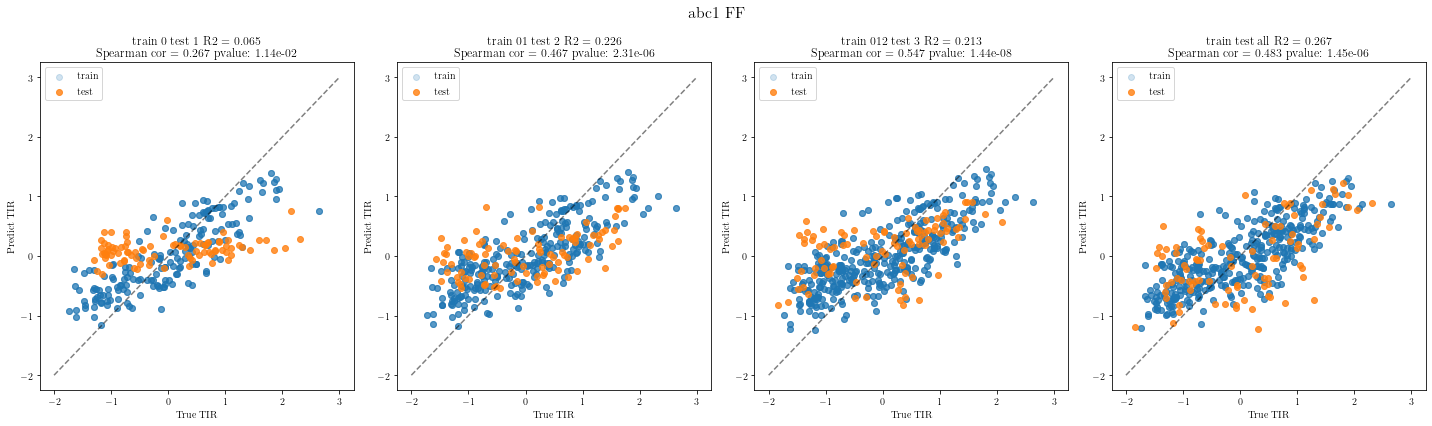

In [15]:
scatter_plot(df_abc1_FF_predictors, 
            ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc1 FF')

In [16]:
centering_flag = True
unit_norm_flag = True
df_abc2_TT_predictors = generate_predictors(df_abc2, kernel, embedding, centering_flag, unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_

#################################
  Evaluation   train 0 test 1
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.06843612823456412
Test:  1.2426049942868824
<function r2_score at 0x7f95e67f8b90>
Train:  0.8009332104608528
Test:  -0.48401467853183555
spearman cor:
Train:  SpearmanrResult(correlation=0.9209524717981566, pvalue=0.0)
Test:  0.17286346612189313   0.10524144088121028
Test pred fit:  [0.00077077 0.44157732]
Test ave fit:  [ 0.03495985 -1.72579054]
coverage rate: 
Train:  0.9943127962085309
Test:  0.6741573033707865
#################################
  Evaluation   train 01 test 2
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.19323571170251838
Test:  1.3483725065696217
<function r2_score at 0x7f95e67f8b90>
Train:  0.636465030565389
Test:  -0.23679916354729813
spearman cor:
Train:  SpearmanrResult(correlation=0.8466823182915151, pvalue=0.0)
Test:  0.5311037088743227   4.3308290654719006e-08


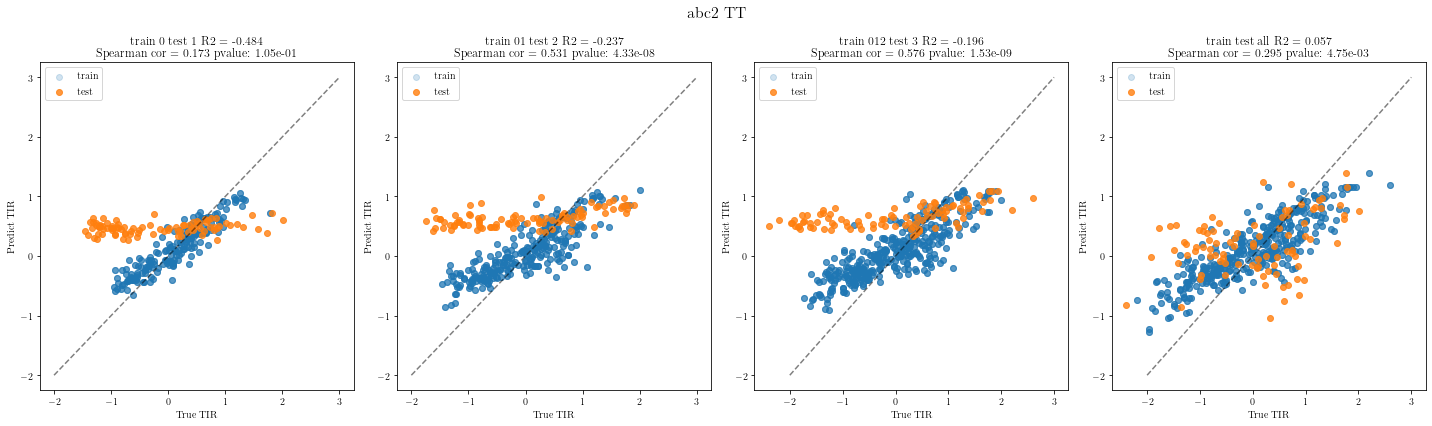

In [17]:
scatter_plot(df_abc2_TT_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc2 TT')

In [18]:
centering_flag = False
unit_norm_flag = False
df_abc2_FF_predictors = generate_predictors(df_abc2, kernel, embedding, centering_flag, unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigm

#################################
  Evaluation   train 0 test 1
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.11155897849871084
Test:  0.9339002208266061
<function r2_score at 0x7f95e67f8b90>
Train:  0.675497602408358
Test:  -0.11533563953376147
spearman cor:
Train:  SpearmanrResult(correlation=0.8520287169792676, pvalue=2.9850929635115326e-298)
Test:  0.2627511065713313   0.012860022327532129
Test pred fit:  [0.00112971 0.14257311]
Test ave fit:  [ 0.03495985 -1.72579054]
coverage rate: 
Train:  0.943127962085308
Test:  0.550561797752809
#################################
  Evaluation   train 01 test 2
#################################
<function mean_squared_error at 0x7f95e67f8950>
Train:  0.2591592992571607
Test:  0.9100558717358737
<function r2_score at 0x7f95e67f8b90>
Train:  0.5124427720731743
Test:  0.1652482266879275
spearman cor:
Train:  SpearmanrResult(correlation=0.7488115952234794, pvalue=8.775247731668308e-286)
Test:  0.46700511

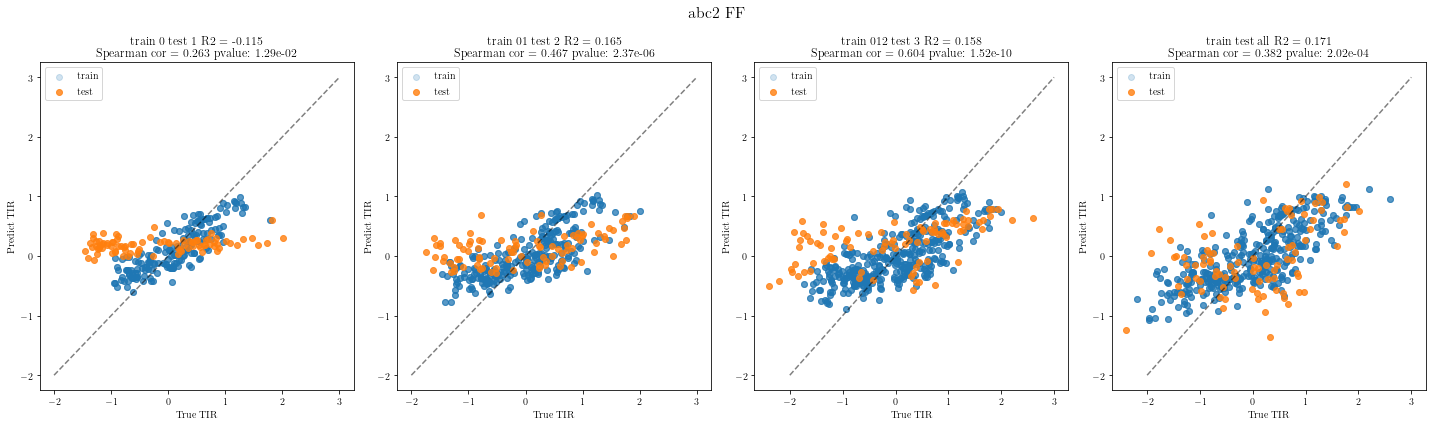

In [19]:
scatter_plot(df_abc2_FF_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc2 FF')